### Importing Important Libraries

#### Steps To Be Followed
1. Importing necessary Libraries
2. Creating S3 bucket 
3. Mapping train And Test Data in S3
4. Mapping The path of the models in S3

In [1]:
import sagemaker
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri 
from sagemaker.session import s3_input, Session

In [55]:
#listing all the buckets
bucks=boto3.resource("s3")
for bucket in bucks.buckets.all():
    print(bucket.name)

awsbucketdp1
sagemaker-ap-south-1-138213122923


#### Creating a bucket

In [9]:
#bucket creation
def create(region,name):
    s3=boto3.resource("s3")
    region_name=boto3.session.Session().region_name
    try:
        if region_name==region:
            s3.create_bucket(Bucket=name)
            print("bucket created successfully!")
    except Exception as e:
        print("s3 error",e)

In [2]:
# bucket_name = 'name' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
# my_region = boto3.session.Session().region_name # set the region of the instance
# print(my_region)
# s3 = boto3.resource('s3')
# try:
#     if  my_region == 'ap-south-1':
#         s3.create_bucket(Bucket=bucket_name)
#     print('S3 bucket created successfully')
# except Exception as e:
#     print('S3 error: ',e)

ap-south-1


In [14]:
# set an output path where the trained model will be saved
prefix = 'xgboost-as-a-built-in-algo'
bucket_name="awsbucketdp1"
output_path ='s3://{}/{}/output'.format(bucket_name, prefix)
print(output_path)

s3://awsbucketdp1/xgboost-as-a-built-in-algo/output


#### Downloading The Dataset And Storing in S3

In [15]:
import pandas as pd
import urllib
try:
    urllib.request.urlretrieve ("https://d1.awsstatic.com/tmt/build-train-deploy-machine-learning-model-sagemaker/bank_clean.27f01fbbdf43271788427f3682996ae29ceca05d.csv", "bank_clean.csv")
    print('Success: downloaded bank_clean.csv.')
except Exception as e:
    print('Data load error: ',e)

try:
    model_data = pd.read_csv('./bank_clean.csv',index_col=0)
    print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: downloaded bank_clean.csv.
Success: Data loaded into dataframe.


In [16]:
### Train(x_train+y_train) Test(x_test_y_test) split()

import numpy as np
train_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data))])
print(train_data.shape, test_data.shape)

(28831, 61) (12357, 61)


In [18]:
### Saving Train And Test Into Buckets
## We start with Train Data
import os
pd.concat([train_data['y_yes'], train_data.drop(['y_no', 'y_yes'], 
                                                axis=1)], 
                                                axis=1).to_csv('train.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

In [20]:
# Test Data Into Buckets
pd.concat([test_data['y_yes'], test_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('test.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')
s3_input_test = sagemaker.TrainingInput(s3_data='s3://{}/{}/test'.format(bucket_name, prefix), content_type='csv')

### Building Models Xgboost- Inbuilt Algorithm

In [23]:
# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
# specify the repo_version depending on your preference.

from sagemaker import image_uris
container=image_uris.retrieve("xgboost",boto3.session.Session().region_name,version='1.0-1')

In [24]:
# initialize hyperparameters
hyperparameters = {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "subsample":"0.7",
        "objective":"binary:logistic",
        "num_round":50
        }

In [26]:
# construct a SageMaker estimator that calls the xgboost-container
estimator = sagemaker.estimator.Estimator(image_uri=container, 
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(),
                                          train_instance_count=1, 
                                          train_instance_type='ml.m5.2xlarge', 
                                          train_volume_size=5, # 5 GB 
                                          output_path=output_path,
                                          train_use_spot_instances=True,
                                          train_max_run=300,
                                          train_max_wait=600)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_use_spot_instances has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_wait has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [27]:
estimator.fit({'train': s3_input_train,'validation': s3_input_test})

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-09-03-18-00-17-646


2023-09-03 18:00:17 Starting - Starting the training job...
2023-09-03 18:00:39 Starting - Preparing the instances for training.........
2023-09-03 18:02:11 Downloading - Downloading input data......
2023-09-03 18:03:12 Training - Training image download completed. Training in progress..[2023-09-03 18:03:14.115 ip-10-0-136-56.ap-south-1.compute.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Single n

### Deploy Machine Learning Model As Endpoints

In [28]:
xgb_predictor = estimator.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-09-03-18-09-25-266
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-09-03-18-09-25-266
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-09-03-18-09-25-266


-----!

#### Prediction of the Test Data

In [31]:
from sagemaker.serializers import CSVSerializer
test_data_array = test_data.drop(['y_no', 'y_yes'], axis=1).values #load the data into an array
xgb_predictor.content_type = 'text/csv' # set the data type for an inference
xgb_predictor.serializer = CSVSerializer(content_type = 'text/csv') # set the serializer type
predictions = xgb_predictor.predict(test_data_array).decode('utf-8') # predict!
predictions_array = np.fromstring(predictions[1:], sep=',') # and turn the prediction into an array
print(predictions_array.shape)

(12357,)


In [32]:
predictions_array

array([0.05214286, 0.05660191, 0.05096195, ..., 0.03436061, 0.02942475,
       0.03715819])

In [33]:
cm = pd.crosstab(index=test_data['y_yes'], columns=np.round(predictions_array), rownames=['Observed'], colnames=['Predicted'])
tn = cm.iloc[0,0]; fn = cm.iloc[1,0]; tp = cm.iloc[1,1]; fp = cm.iloc[0,1]; p = (tp+tn)/(tp+tn+fp+fn)*100
print("\n{0:<20}{1:<4.1f}%\n".format("Overall Classification Rate: ", p))
print("{0:<15}{1:<15}{2:>8}".format("Predicted", "No Purchase", "Purchase"))
print("Observed")
print("{0:<15}{1:<2.0f}% ({2:<}){3:>6.0f}% ({4:<})".format("No Purchase", tn/(tn+fn)*100,tn, fp/(tp+fp)*100, fp))
print("{0:<16}{1:<1.0f}% ({2:<}){3:>7.0f}% ({4:<}) \n".format("Purchase", fn/(tn+fn)*100,fn, tp/(tp+fp)*100, tp))


Overall Classification Rate: 89.7%

Predicted      No Purchase    Purchase
Observed
No Purchase    91% (10785)    34% (151)
Purchase        9% (1124)     66% (297) 



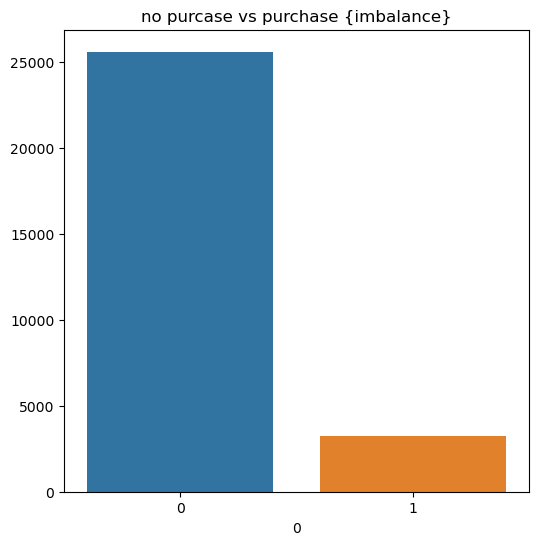

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

client=boto3.client("s3")
train_csv=client.get_object(
        Bucket="awsbucketdp1",
        Key="xgboost-as-a-built-in-algo/train/train.csv"
)
df_train=pd.read_csv(train_csv["Body"])
target=df_train['0'].value_counts()

plt.figure(figsize=(6,6))
sns.barplot(x=target.index,y=target.values)
plt.title("no purcase vs purchase {imbalance}")
plt.show()

#### Deleting The Endpoints

In [58]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)
bucket_to_delete = boto3.resource('s3').Bucket(bucket_name)
bucket_to_delete.objects.all().delete()

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Deleting endpoint with name: sagemaker-xgboost-2023-09-03-18-09-25-266


[]